In [1]:
# # Google Colab specific
# %cd ~/../content
# !rm -rf openet

# !git clone https://github.com/aetriusgx/openet.git
# %cd openet

# Data Preparation

In [2]:
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import geopandas as gpd
import json
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [3]:
# Styling Cell
sns.set_theme(context="notebook", style="whitegrid")

SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Historical Data Import

In [4]:
historical = pd.read_csv('./data/kern_historical.csv', low_memory=False)
historical['time'] = pd.to_datetime(historical['time'])
historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3406782 entries, 0 to 3406781
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   field_id     object        
 1   crop         int64         
 2   time         datetime64[ns]
 3   actual_et    float64       
 4   actual_eto   float64       
 5   actual_etof  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 156.0+ MB


## Forecast Table Build

In [5]:
# Gather current forecast data for the county
forecasting_table = pd.DataFrame()
files = Path(f"data/forecasts/kern/").glob("*.csv")

for file in files:
    # splits into [$date, 'forecast.csv']
    parts = str(file.name).split("_")
    data = pd.read_csv(file, low_memory=False)
    data["forecasting_date"] = parts[0]
    forecasting_table = pd.concat([data, forecasting_table], ignore_index=True)

forecasting_table['forecasting_date'] = pd.to_datetime(forecasting_table['forecasting_date'])
forecasting_table['time'] = pd.to_datetime(forecasting_table['time'])
forecasting_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11924280 entries, 0 to 11924279
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   field_id          object        
 1   crop              int64         
 2   time              datetime64[ns]
 3   expected_et       float64       
 4   expected_eto      float64       
 5   expected_etof     float64       
 6   forecasting_date  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 636.8+ MB


## Main Data Table compilation

In [6]:
dt = historical.loc[(historical['time'].dt.year == 2024), :]
dt = dt.merge(forecasting_table, on=['field_id', 'time', 'crop'], how='right').set_index(['forecasting_date', 'field_id', 'crop', 'time']).reset_index()
dt = dt[(dt['time'].dt.month < 8)]
dt

forecasting_date   field_id  crop       time  actual_et  actual_eto  \
0              2024-07-22   CA_27267    61 2024-01-01      0.043       0.951   
1              2024-07-22   CA_27267    61 2024-01-02      0.030       0.740   
2              2024-07-22   CA_27267    61 2024-01-03      0.062       1.691   
3              2024-07-22   CA_27267    61 2024-01-04      0.062       1.902   
4              2024-07-22   CA_27267    61 2024-01-05      0.039       1.374   
...                   ...        ...   ...        ...        ...         ...   
11924122       2024-01-01  CA_423678    61 2024-07-27      0.844       7.681   
11924123       2024-01-01  CA_423678    61 2024-07-28      0.808       7.351   
11924124       2024-01-01  CA_423678    61 2024-07-29      0.771       7.020   
11924125       2024-01-01  CA_423678    61 2024-07-30      0.790       7.185   
11924126       2024-01-01  CA_423678    61 2024-07-31      0.699       6.360   

          actual_etof  expected_et  expected_eto  expected_etof  
0               0.045        0.043         0.951          0.045  
1               0.041        0.030         0.740          0.041  
2               0.037        0.062         1.691          0.037  
3               0.032        0.062         1.902          0.032  
4               0.028        0.039         1.374          0.028  
...               ...          ...           ...            ...  
11924122        0.110        5.537         8.238          0.562  
11924123        0.110        5.776         7.805          0.567  
11924124        0.110        5.933         7.443          0.572  
11924125        0.110        6.009         7.412          0.578  
11924126        0.110        6.012         7.349          0.585  

[6939540 rows x 10 columns]

### Add geographical data

In [7]:
# Add additional data to the data table
kern_points = pd.read_csv("./data/Kern.csv", low_memory=False).set_index("OPENET_ID").rename_axis("field_id")

# Expand .geo column into lon, lat columns
kern_geo = (kern_points[".geo"]
                .apply(lambda x: pd.Series(dict(json.loads(x))))['coordinates']
                .apply(lambda x: pd.Series(list(x), index=['longitude', 'latitude'])))
kern_geo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1086 entries, CA_33179 to CA_39812
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  1086 non-null   float64
 1   latitude   1086 non-null   float64
dtypes: float64(2)
memory usage: 25.5+ KB


### Add USDA crop data

In [8]:
# Add crop data
cdl_codes = pd.read_csv("./data/cdl_codes.csv", low_memory=False).set_index("Codes")

dt = dt.join(cdl_codes, how="left", on="crop", validate="many_to_many")
dt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6939540 entries, 0 to 11924126
Data columns (total 17 columns):
 #   Column            Dtype         
---  ------            -----         
 0   forecasting_date  datetime64[ns]
 1   field_id          object        
 2   crop              int64         
 3   time              datetime64[ns]
 4   actual_et         float64       
 5   actual_eto        float64       
 6   actual_etof       float64       
 7   expected_et       float64       
 8   expected_eto      float64       
 9   expected_etof     float64       
 10  Class_Names       object        
 11  ESRI_Red          int64         
 12  ESRI_Green        int64         
 13  ESRI_Blue         int64         
 14  Erdas_Red         float64       
 15  Erdas_Green       float64       
 16  Erdas_Blue        float64       
dtypes: datetime64[ns](2), float64(9), int64(4), object(2)
memory usage: 953.0+ MB


### Add Field Metadata

In [9]:
# Import table using only field and hectare columns
field_metadata = pd.read_json('./data/geo/kern_metadata.json')[['field_id', 'hectares']]
# Reformat field IDs to be same convention as the other tables.
field_metadata['field_id'] = 'CA_' + field_metadata['field_id'].astype(str).str[1:]
field_metadata = field_metadata.set_index('field_id')
field_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1085 entries, CA_27267 to CA_42345
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   hectares  1085 non-null   float64
dtypes: float64(1)
memory usage: 17.0+ KB


In [10]:
dt = dt.join(field_metadata, how='left', on='field_id', validate='many_to_one')
dt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6939540 entries, 0 to 11924126
Data columns (total 18 columns):
 #   Column            Dtype         
---  ------            -----         
 0   forecasting_date  datetime64[ns]
 1   field_id          object        
 2   crop              int64         
 3   time              datetime64[ns]
 4   actual_et         float64       
 5   actual_eto        float64       
 6   actual_etof       float64       
 7   expected_et       float64       
 8   expected_eto      float64       
 9   expected_etof     float64       
 10  Class_Names       object        
 11  ESRI_Red          int64         
 12  ESRI_Green        int64         
 13  ESRI_Blue         int64         
 14  Erdas_Red         float64       
 15  Erdas_Green       float64       
 16  Erdas_Blue        float64       
 17  hectares          float64       
dtypes: datetime64[ns](2), float64(10), int64(4), object(2)
memory usage: 1005.9+ MB


### List of identifiers

In [11]:
forecast_dates = forecasting_table['forecasting_date'].unique()
fields = dt['field_id'].unique()
crops = dt['crop'].unique()

# Analysis

## Helpers
Below are functions that are being used to calculate data and generate plots.

The tables below are also calculated prior to speed up metric calculations.

### Average ET/ETo/ETof for 2024
This table will be used as a reference for any metric and plot calculations

In [12]:
avgs_table = dt.groupby(['field_id', 'crop'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean')
avgs_table.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1086 entries, ('CA_27267', 61) to ('CA_423678', 61)
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   actual_et    1086 non-null   float64
 1   actual_eto   1086 non-null   float64
 2   actual_etof  1086 non-null   float64
dtypes: float64(3)
memory usage: 37.4+ KB


### Climatology Reference
The table below records the average conditions for each field for each day of the year.

In [13]:
# Create a column for day of year
historical['doy'] = historical['time'].dt.dayofyear
# Group by field, crop, and doy then calculate the average conditions
climatology_table = historical.groupby(['field_id', 'crop', 'doy'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean')
climatology_table.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 397476 entries, ('CA_27267', 61, 1) to ('CA_423678', 61, 366)
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   actual_et    397476 non-null  float64
 1   actual_eto   397476 non-null  float64
 2   actual_etof  397476 non-null  float64
dtypes: float64(3)
memory usage: 11.0+ MB


### calculate_metrics
This function calculate the mean absolute error (mae), root mean squared error (rmse), mean forecast error (bias), correlation coefficient (R), and skill score.

MAE, RMSE, and R are calculated using sklearn's metric module.

Skill score is calculated by getting the climatology for each field within the input's date range.
* Negative skill scores indicate the MSE for forecast is larger than the MSE for climatology
* Positive skill scores indicate otherwise

The function is very flexible given the data is formatted appropriately. It has the option of enabling normalization which is based on the average specified variable (ET, ETo, or ETof) throughout that field's historical data.

In [14]:
def calculate_metrics(data: pd.DataFrame, *, historical: pd.DataFrame, actual: str, expected: str, normalize: bool = False) -> pd.Series:
	# Calculate error metrics
	mae: float = mean_absolute_error(data[actual], data[expected])
	forecast_mse: float = mean_squared_error(data[actual], data[expected])
	rmse: float = np.sqrt(forecast_mse)

    # Correlation Coefficient (R)
	cor = data[actual].corr(data[expected]).astype(float)
    
    # Mean Forecast Bias determines if the forecast is overshooting or undershooting.
    # Greater positive number indicates overshooting.
	bias: float = np.mean(data[expected] - data[actual])

	# Climatology uses the mean actual variable for that time of year using historical data.
	field = data.head(1).squeeze()
	start_date = data['time'].min().dayofyear
	end_date = data['time'].max().dayofyear

	# Filter the climatology reference
	field_mask = (climatology_table.index.get_level_values(0) == field['field_id'])
	crop_mask = (climatology_table.index.get_level_values(1) == field['crop'])
	date_mask = ((climatology_table.index.get_level_values(2) >= start_date) & (climatology_table.index.get_level_values(2) <= end_date))

	climatology = climatology_table[field_mask & crop_mask & date_mask][actual]
	climatology_mse = mean_squared_error(data[actual], climatology)

	# Positive skill score indicates the error in climatology is greater than forecast.
    # This means that forecast is outperforming climatology.
	skill_score = 1 - np.max(np.min((forecast_mse / climatology_mse), initial=2), initial=-1)

	if normalize:
		avg: float = avgs_table[avgs_table.index.get_level_values(0) == field['field_id']][actual].values[0]

		mae: float = mae.astype(float) / avg.astype(float)
		rmse = np.sqrt(forecast_mse.astype(float) / avg.astype(float))
		bias = bias.astype(float) / avg.astype(float)

	return pd.Series({
		'mae': mae.round(2),
		'rmse': rmse.round(2),
		'corr': cor.round(2),
		'bias': bias.round(2),
		'skill_score': skill_score.round(2)
	})

### eval_metrics
This function evaluates the metrics for each variable. The output is a DataFrame containing the metrics with a column specifying which variable (ET, ETo, ETof)

In [15]:
def eval_metrics(table: pd.DataFrame, by=['field_id', 'crop'], **kwargs) -> pd.DataFrame:
    metrics_table = pd.DataFrame(columns=["field_id", "variable", "crop", "mae", "rmse", "corr", "bias", "skill_score"])

    et_metrics = table.groupby(by=by)[["field_id", "crop", "time", "actual_et", "expected_et"]].apply(calculate_metrics, historical=historical,
                                                                      actual='actual_et', expected='expected_et', **kwargs).reset_index()
    et_metrics['variable'] = "ET"

    metrics_table = pd.concat([et_metrics.astype(metrics_table.dtypes), metrics_table.astype(et_metrics.dtypes)], ignore_index=True)

    eto_metrics = table.groupby(by=by)[["field_id", "crop", "time", "actual_eto", "expected_eto"]].apply(calculate_metrics, historical=historical,
                                                                      actual='actual_eto', expected='expected_eto', **kwargs).reset_index()
    eto_metrics['variable'] = "ETo"
    metrics_table = pd.concat([eto_metrics.astype(metrics_table.dtypes), metrics_table.astype(eto_metrics.dtypes)], ignore_index=True)

    etof_metrics = table.groupby(by=by)[["field_id", "crop", "time", "actual_etof", "expected_etof"]].apply(calculate_metrics, historical=historical,
                                                                      actual='actual_etof', expected='expected_etof', **kwargs).reset_index()
    etof_metrics['variable'] = "ETof"
    metrics_table = pd.concat([etof_metrics.astype(metrics_table.dtypes), metrics_table.astype(etof_metrics.dtypes)], ignore_index=True)

    return metrics_table

### timeseries_rel
This plot function utilizes the seaborn relplot method to create grids of plots. Particularly useful for showing distribution on one cell.

In [16]:
def timeseries_rel(data, *, y, plot='rel',
                   col=None, row=None, hue=None, kind='line', 
                   title='', ylabel='', as_percent=False, tighten=False,
                   errorbar=None, export_img: bool|str=None, title_template={}, **kwargs):
    match plot:
        case 'rel':
            rel = sns.relplot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, errorbar=errorbar, **kwargs)
        case 'dis': 
            rel = sns.displot(data=data, x=y, col=col, row=row, hue=hue, kind=kind, **kwargs)
        case 'cat':
            rel = sns.catplot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, errorbar=errorbar, **kwargs)
        case 'lm':
            rel = sns.lmplot(data=data, x='forecasting_date', y=y, col=col, row=row, hue=hue, kind=kind, errorbar=errorbar, **kwargs)
        case _:
            raise Exception('Not a valid plot type.')

    # Relabel y axis
    if ylabel: rel.set_ylabels(ylabel)
    # Relabel x axis
    rel.tick_params(axis='x', rotation=90)
    plt.suptitle(title, y=1.02);
    rel.set_titles(**title_template);

    if as_percent is True:
        for ax in rel.axes.flat:
            ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    if plot != 'dis':
        rel.set_xlabels('Forecasting Date')
        for ax in rel.axes.flat:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))

    if tighten:
        rel.figure.subplots_adjust(wspace=0, hspace=0.1)

    if type(export_img) is bool and export_img is True: 
        rel.savefig(fname=f'images/kern/{str(title)}')
    elif type(export_img) is str: 
        rel.savefig(fname=f'images/kern/{export_img}')

    return rel

### trim_extremes
Trim the edges of the DataFrame along provided columns with provided threshold.

In [17]:
def trim_extremes(data, *, cols, threshold):
    # Convert single input as list
    if type(cols) is not list:
        cols = [cols]
    # Go through each column. Rank the values by % then remove the extremes.
    for c in cols:
        data[f'{c}_pct'] = data[c].rank(pct=True)
        data.drop(index=data[(data[f'{c}_pct'] <= threshold) | (data[f'{c}_pct'] >= (1 - threshold))].index, inplace=True)
        data.drop(columns=f'{c}_pct', inplace=True)
    return data

## Calculation

In [18]:
analysis_end_date = historical['time'].max()

Est. run time: 21m

In [19]:
metrics_norm = (dt[(dt['time'] > dt['forecasting_date']) & (dt['time'] < analysis_end_date)]
                .groupby(['forecasting_date'])[list(dt.columns)]
                .apply(eval_metrics, normalize=True))
metrics_norm.reset_index().to_csv('data/metrics/kern_metrics_normalized.csv', index=False)

C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: in

In [20]:
metrics_norm = pd.read_csv('data/metrics/kern_metrics_normalized.csv').drop(['level_1'], axis=1)
metrics_norm['forecasting_date'] = pd.to_datetime(metrics_norm['forecasting_date'])

In [21]:
metrics_norm = (metrics_norm.groupby(['forecasting_date', 'variable'])[['field_id', 'crop', 'mae', 'rmse', 'bias', 'corr', 'skill_score']]
                .apply(trim_extremes, cols=['mae', 'rmse', 'bias', 'corr', 'skill_score'], threshold=0.02))
metrics_norm.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 82159 entries, (Timestamp('2024-01-01 00:00:00'), 'ET', 2172) to (Timestamp('2024-07-22 00:00:00'), 'ETof', 95567)
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   field_id     82159 non-null  object 
 1   crop         82159 non-null  int64  
 2   mae          82159 non-null  float64
 3   rmse         82159 non-null  float64
 4   bias         82159 non-null  float64
 5   corr         81570 non-null  float64
 6   skill_score  82159 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 7.5+ MB


### Crop metrics

In [22]:
crop_metrics = (dt[(dt['time'] > dt['forecasting_date']) & (dt['time'] < analysis_end_date)]
                .groupby(by=['forecasting_date', 'crop'])[list(dt.columns)]
                .apply(eval_metrics, normalize=True))
crop_metrics.to_csv('data/metrics/kern_crop_metrics.csv')

C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: in

In [23]:
crop_metrics = pd.read_csv('data/metrics/kern_crop_metrics.csv', low_memory=False).drop(['Unnamed: 2', 'crop.1'], axis=1)
crop_metrics['forecasting_date'] = pd.to_datetime(crop_metrics['forecasting_date'])

In [24]:
crop_metrics = (crop_metrics.groupby(['forecasting_date', 'variable'])[['field_id', 'crop', 'mae', 'rmse', 'bias', 'corr', 'skill_score']]
                    .apply(trim_extremes, cols=['mae', 'rmse', 'bias', 'corr', 'skill_score'], threshold=0.02))
                    
crop_metrics.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 82159 entries, (Timestamp('2024-01-01 00:00:00'), 'ET', 45) to (Timestamp('2024-07-22 00:00:00'), 'ETof', 97652)
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   field_id     82159 non-null  object 
 1   crop         82159 non-null  int64  
 2   mae          82159 non-null  float64
 3   rmse         82159 non-null  float64
 4   bias         82159 non-null  float64
 5   corr         81570 non-null  float64
 6   skill_score  82159 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 7.5+ MB


# Visualization

## Metric Correlation

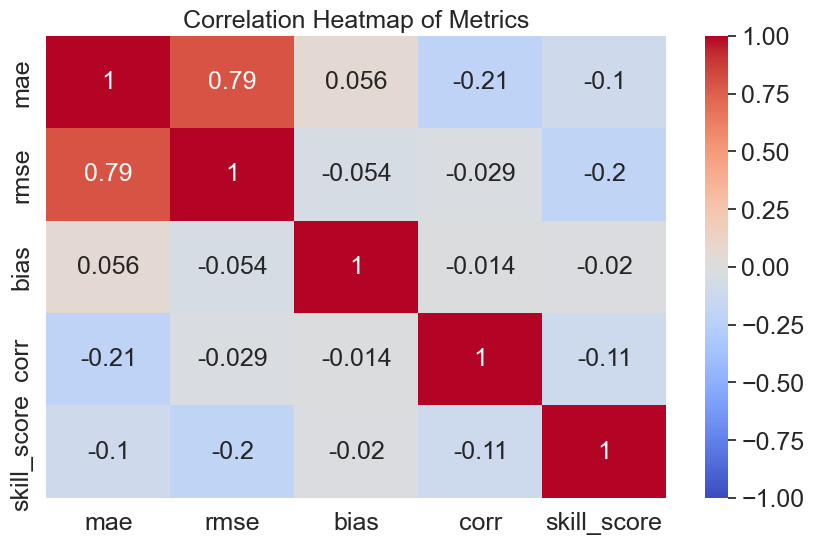

In [25]:
plt.figure(figsize=(10, 6))
metrics = ['mae', 'rmse', 'bias', 'corr', 'skill_score']
corr_matrix = metrics_norm[metrics].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Metrics')
plt.savefig('images/kern/field_metric_correlation.png')

## Distribution of Metrics

In [26]:
# First reshape data from wide-form to long-form
metrics_long = metrics_norm.reset_index().melt(id_vars=['forecasting_date', 'field_id', 'crop', 'variable'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')

In [27]:
# To help with visualization, map proper names to the stats
stat_propers = {
    'mae': 'Mean Absolute Error',
    'rmse': 'Root Mean Absolute Error',
    'bias': 'Mean Forecast Bias',
    'corr': 'Correlation Coefficient',
    'skill_score': 'Skill Score'
}
metrics_long['name'] = metrics_long['stat'].map(stat_propers)
metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246477 entries, 0 to 246476
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   forecasting_date  246477 non-null  datetime64[ns]
 1   field_id          246477 non-null  object        
 2   crop              246477 non-null  int64         
 3   variable          246477 non-null  object        
 4   stat              246477 non-null  object        
 5   value             246477 non-null  float64       
 6   name              246477 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 13.2+ MB


### Boxplot Distribution

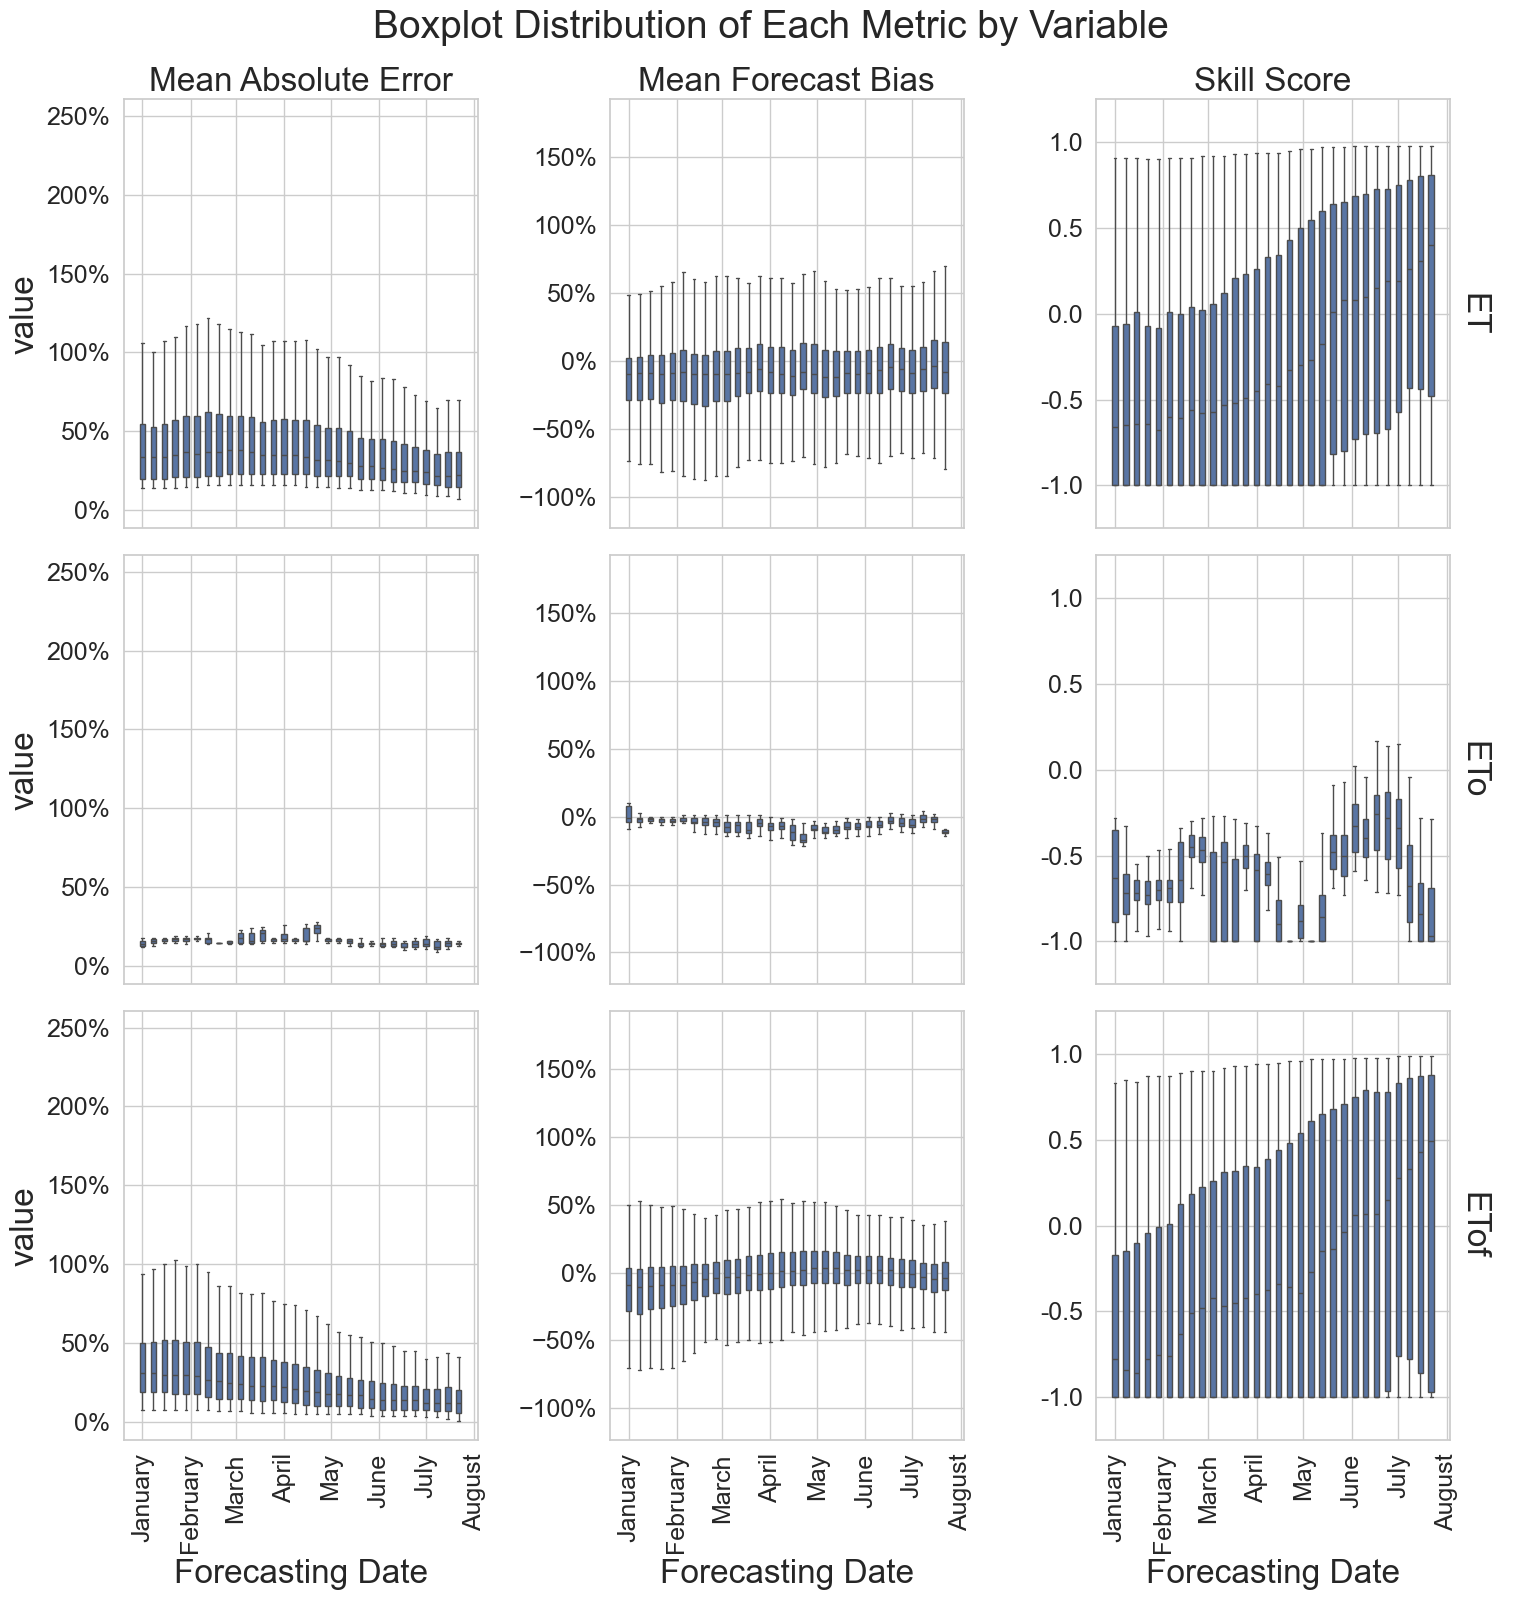

In [28]:
rel = timeseries_rel(data=metrics_long, plot='cat', kind='box',
                y='value', col='name', row='variable',
                width=0.5, errorbar='sd',
                flierprops=dict(markersize=0), title="Boxplot Distribution of Each Metric by Variable",
                export_img='field_boxplots.png', as_percent=True, margin_titles=True,
                row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                facet_kws={"despine": False}, sharey='col', native_scale=True
               );
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('images/kern/field_boxplots.png')

### Metric Distrbution by Standard Deviation

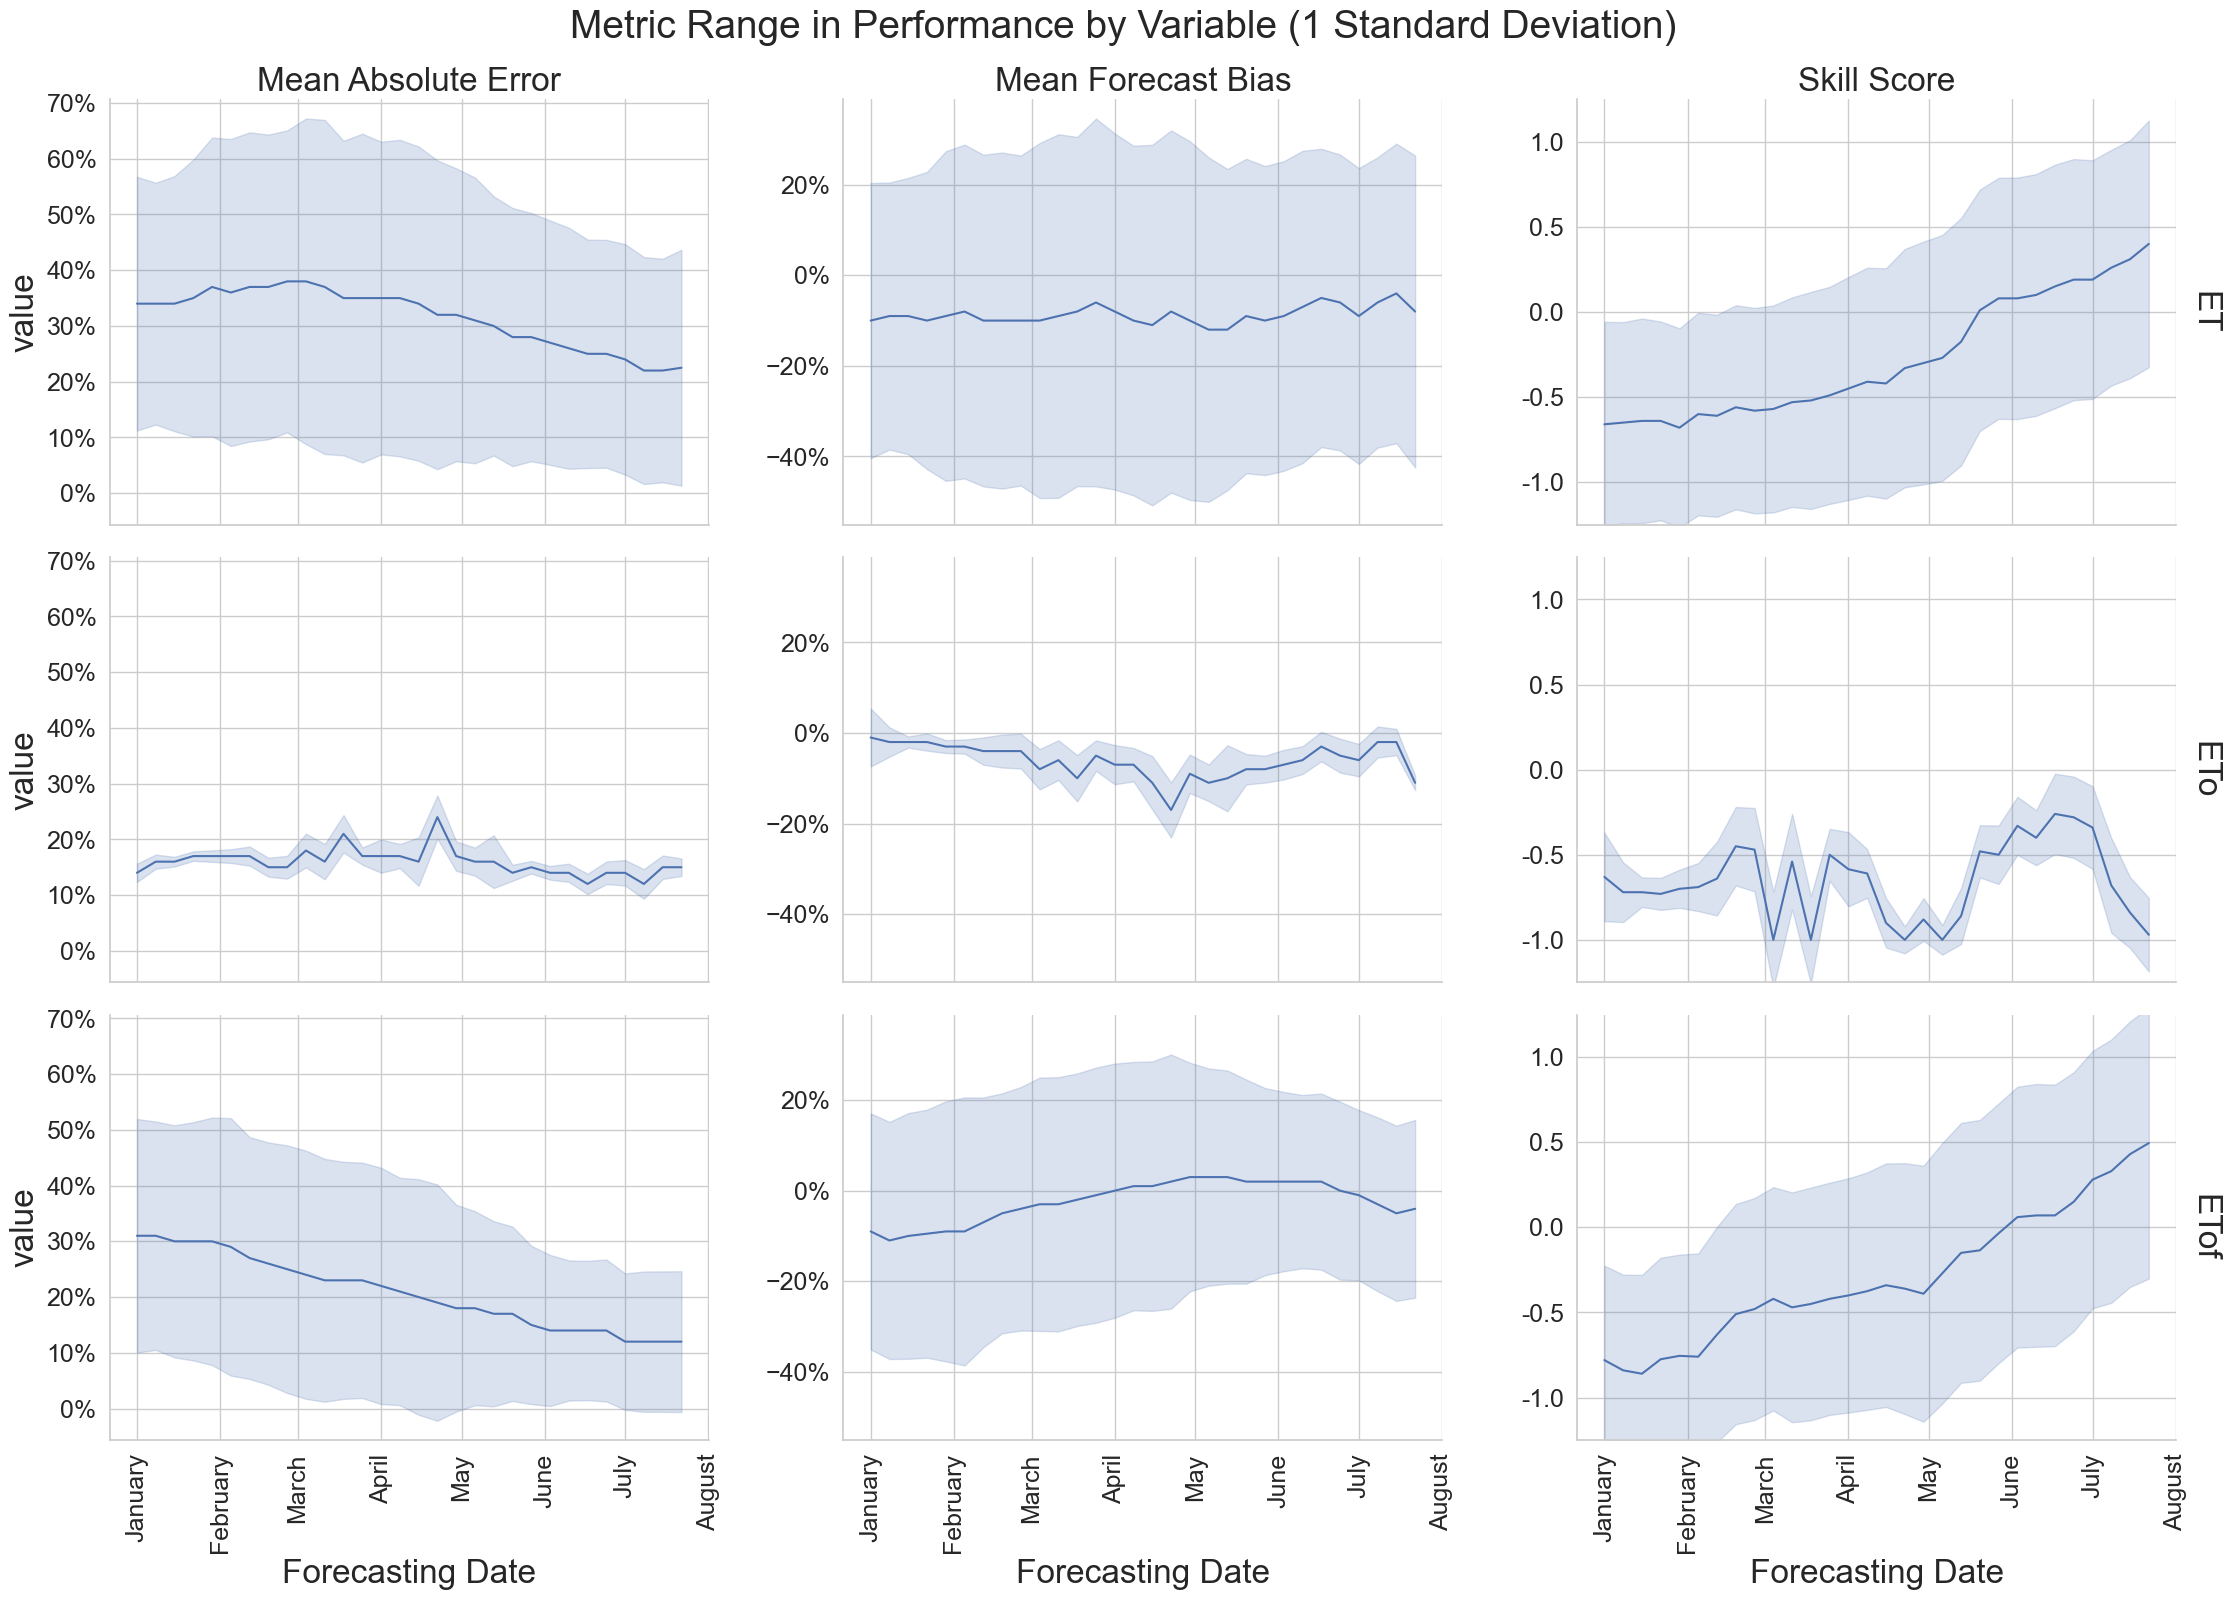

In [29]:
rel = timeseries_rel(metrics_long, row='variable', col='name', y='value',
                     errorbar='sd', estimator=np.median, as_percent=True,
                     facet_kws={'sharey': 'col', 'sharex': True, 'margin_titles': True}, aspect=1.5,
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Metric Range in Performance by Variable (1 Standard Deviation)");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('images/kern/field_metric_range_sd.png')

## Crop Metrics

In [30]:
# Reappend class names of crops for better readability in plots.
metrics_long = metrics_long.join(cdl_codes, how="left", on="crop", validate="many_to_many")

In [31]:
# crop_selector = dt.groupby('crop')['hectares'].agg('sum')[:3]
crop_selector = [69, 72, 75]

In [32]:
dt[dt['crop'].isin(crop_selector)].groupby('crop')['field_id'].nunique()

crop
69    181
72    130
75    228
Name: field_id, dtype: int64

In [33]:
crop_plotter = metrics_long[metrics_long['crop'].isin(crop_selector)]
crop_plotter.head()

forecasting_date   field_id  crop variable stat  value  \
1        2024-01-01  CA_297922    75       ET  mae   0.68   
7        2024-01-01  CA_298100    69       ET  mae   0.21   
8        2024-01-01  CA_298141    72       ET  mae   0.28   
9        2024-01-01  CA_298142    72       ET  mae   0.25   
10       2024-01-01  CA_298170    72       ET  mae   0.26   

                   name Class_Names  ESRI_Red  ESRI_Green  ESRI_Blue  \
1   Mean Absolute Error     Almonds         0         168        132   
7   Mean Absolute Error      Grapes       112          68        137   
8   Mean Absolute Error      Citrus       255         255        128   
9   Mean Absolute Error      Citrus       255         255        128   
10  Mean Absolute Error      Citrus       255         255        128   

    Erdas_Red  Erdas_Green  Erdas_Blue  
1      0.0000       0.6471      0.5098  
7      0.4392       0.2667      0.5373  
8      1.0000       1.0000      0.4980  
9      1.0000       1.0000      0.4980  
10     1.0000       1.0000      0.4980

### Probability Distributions

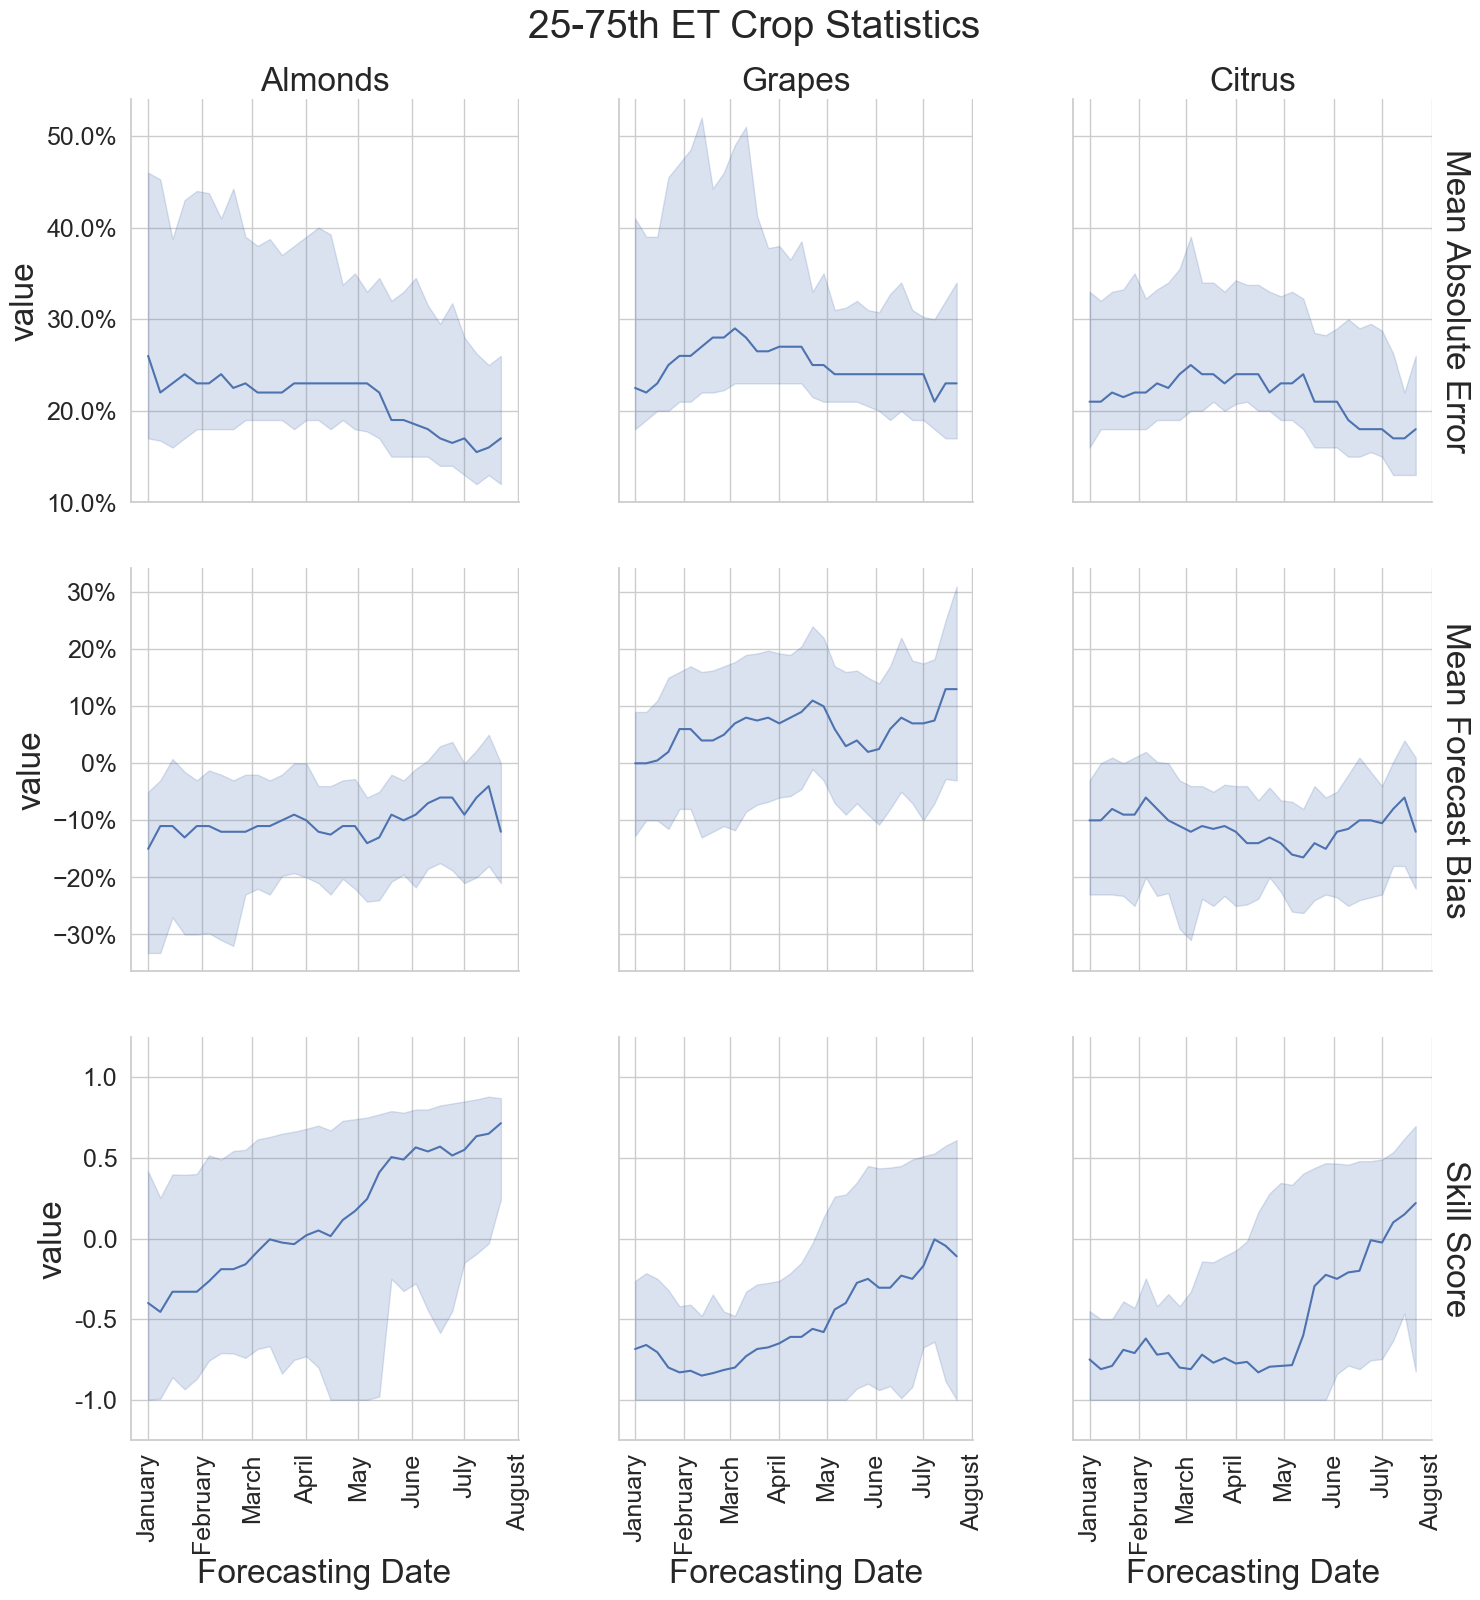

In [34]:
xranges = crop_plotter.groupby(['crop'])['value'].agg(np.ptp) * 1.1
rel = timeseries_rel(crop_plotter[crop_plotter['variable'] == 'ET'], y='value', plot='rel', kind='line',
               col='Class_Names', row='name',
               facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True, 'gridspec_kws':dict(width_ratios=xranges)}, 
               estimator=np.median, errorbar=('pi', 50), title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
               title='25-75th ET Crop Statistics', as_percent=True);
rel.axes.flat[7].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[7].set(ylim=(-1.25, 1.25));
rel.axes.flat[7].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("images/kern/et_crop_stats.png")

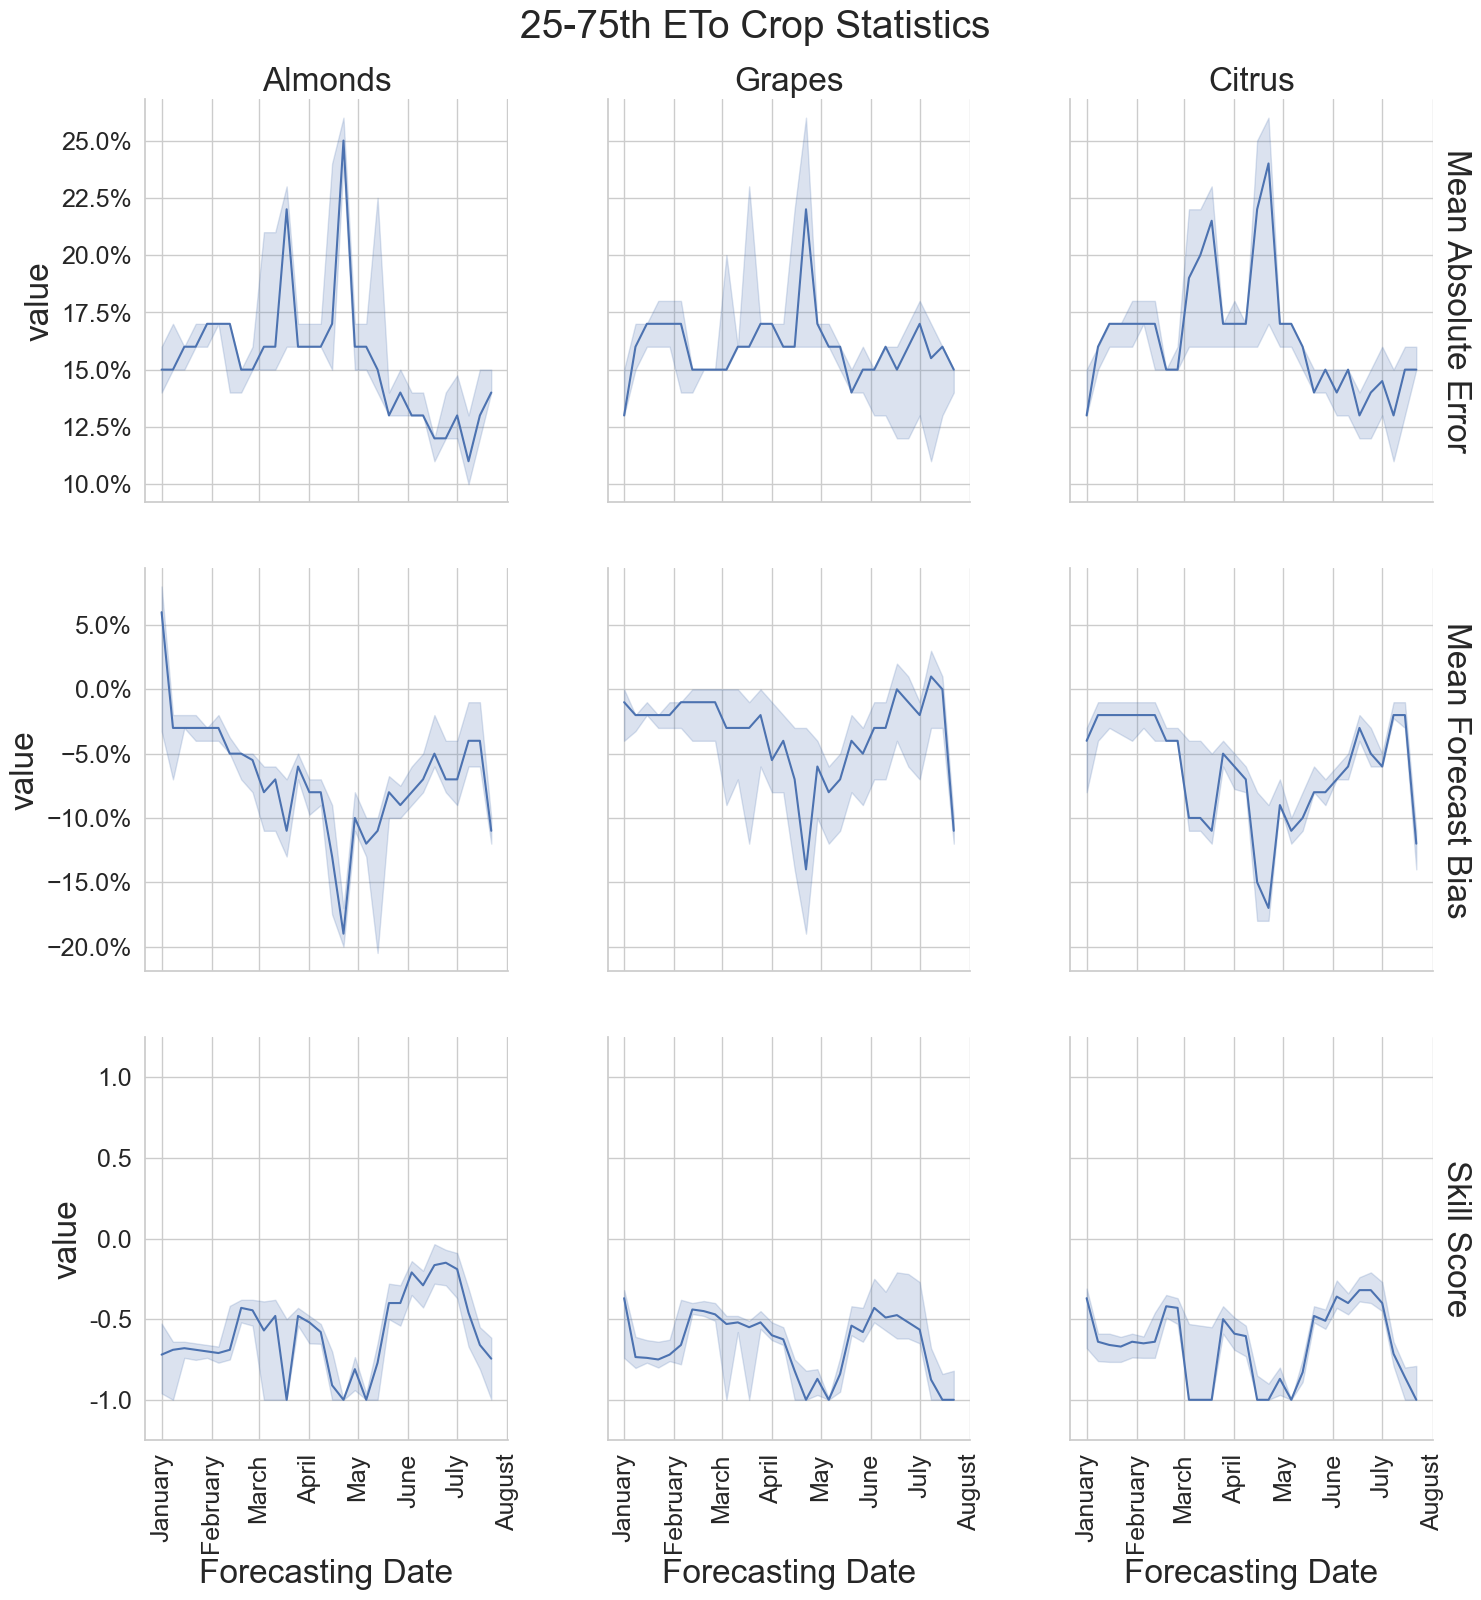

In [35]:
rel = timeseries_rel(crop_plotter[crop_plotter['variable'] == 'ETo'], y='value', plot='rel', kind='line', errorbar=('pi', 50),
                                col='Class_Names', row='name', facet_kws={'sharey': 'row', 'sharex': True, "margin_titles": True}, 
                                estimator=np.median, export_img="eto_crop_stats", title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                                title='25-75th ETo Crop Statistics', as_percent=True);
rel.axes.flat[7].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[7].set(ylim=(-1.25, 1.25));
rel.axes.flat[7].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("images/kern/eto_crop_stats.png")

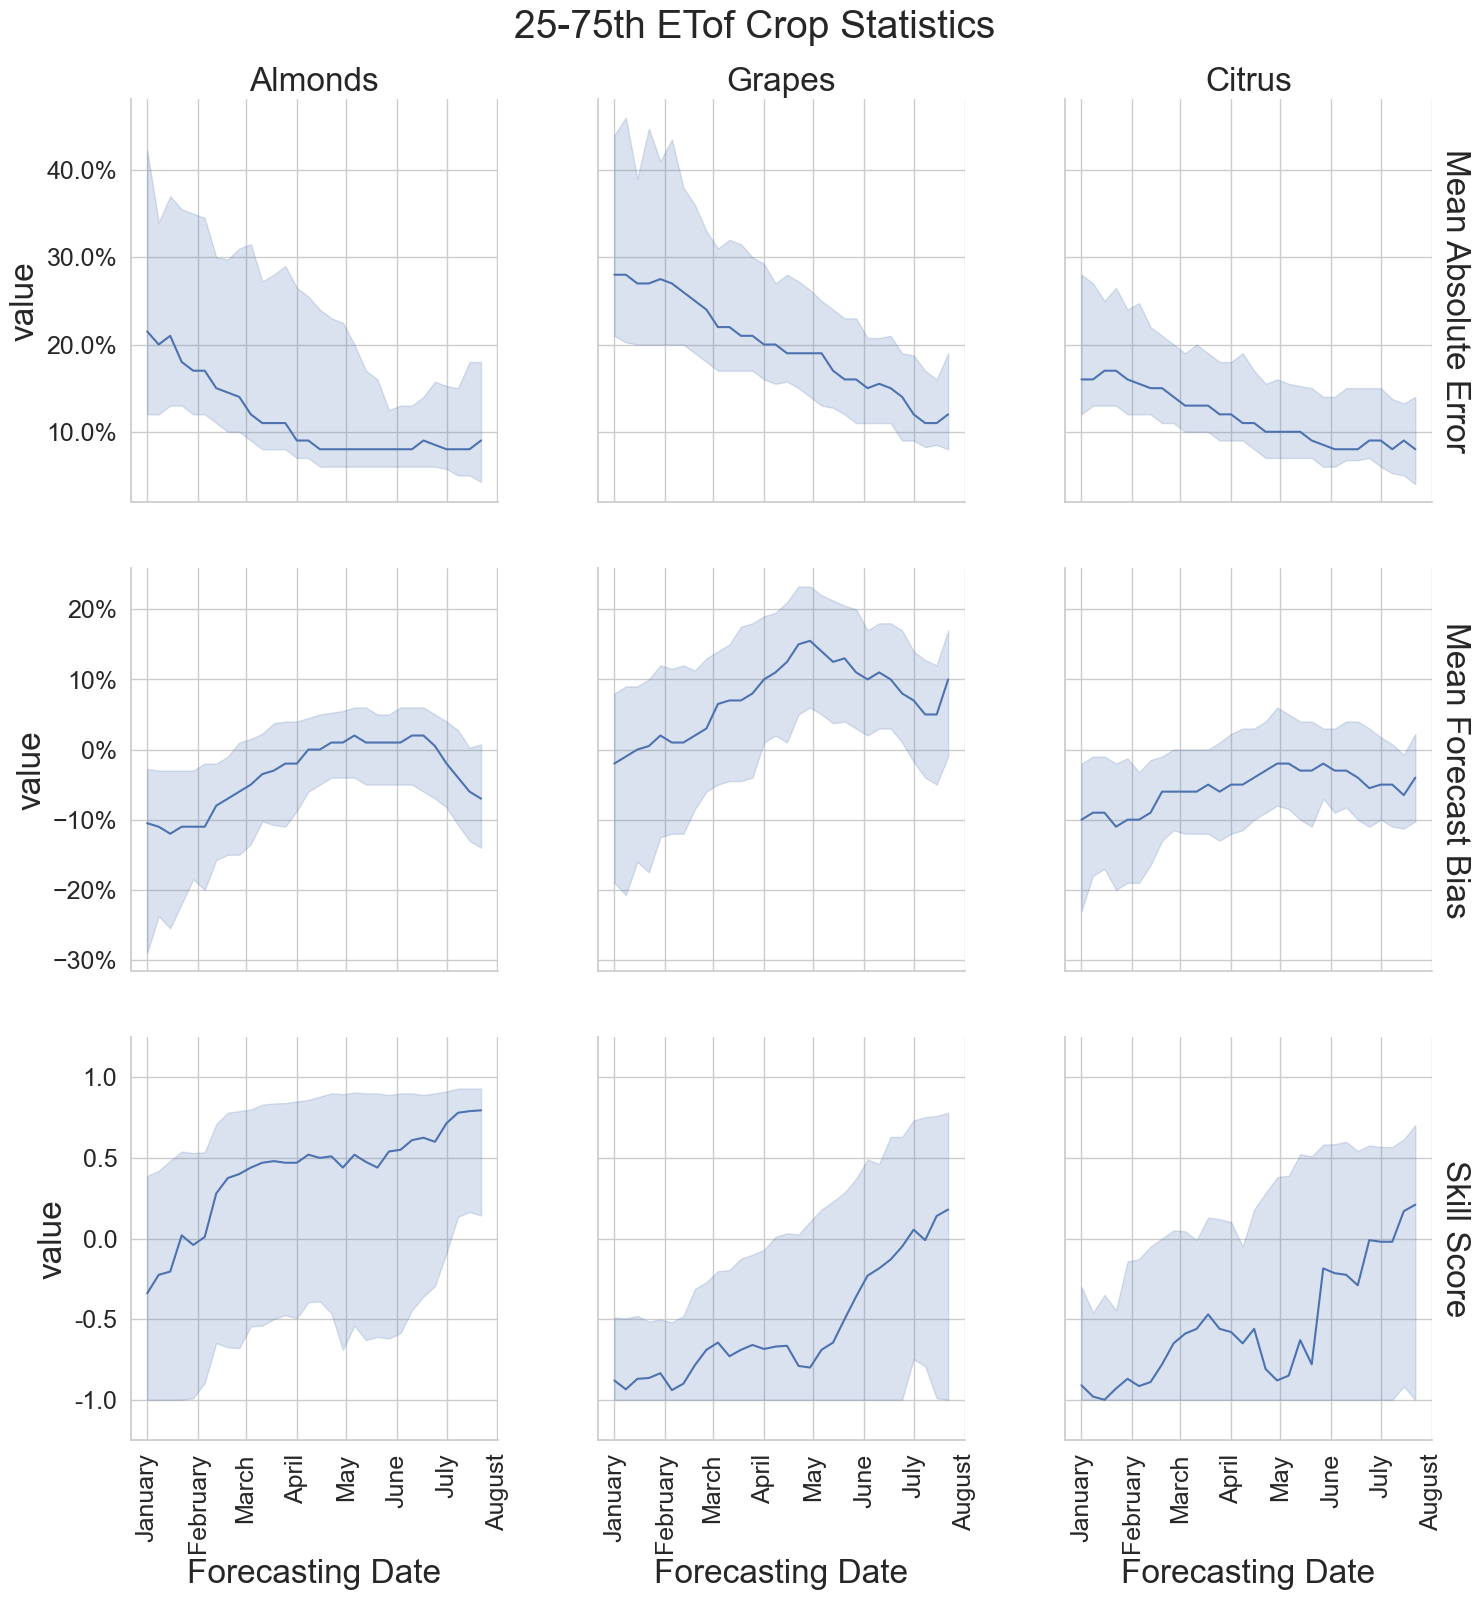

In [36]:
rel = timeseries_rel(crop_plotter[crop_plotter['variable'] == 'ETof'], y='value', plot='rel', kind='line', errorbar=('pi', 50),
                                col='Class_Names', row='name', facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True},
                                estimator=np.median, export_img="etof_crop_metrics", title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                                title='25-75th ETof Crop Statistics', as_percent=True);
rel.axes.flat[7].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[7].set(ylim=(-1.25, 1.25));
rel.axes.flat[7].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("images/kern/etof_crop_stats.png")

## Forecast - Climatology Comparison

In [37]:
metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246477 entries, 0 to 246476
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   forecasting_date  246477 non-null  datetime64[ns]
 1   field_id          246477 non-null  object        
 2   crop              246477 non-null  int64         
 3   variable          246477 non-null  object        
 4   stat              246477 non-null  object        
 5   value             246477 non-null  float64       
 6   name              246477 non-null  object        
 7   Class_Names       246477 non-null  object        
 8   ESRI_Red          246477 non-null  int64         
 9   ESRI_Green        246477 non-null  int64         
 10  ESRI_Blue         246477 non-null  int64         
 11  Erdas_Red         246477 non-null  float64       
 12  Erdas_Green       246477 non-null  float64       
 13  Erdas_Blue        246477 non-null  float64       
dtypes: d

In [38]:
forecast_climatology_metrics = metrics_long[['forecasting_date', 'field_id', 'crop', 'variable', 'stat', 'value']]

## Spatial Plotting

### Preparation

First merge the geo table created in the beginning with the metrics table.

Afterwards, get the average metrics amongst all forecasts.

In [39]:
# Define date range of seasons
winter = (datetime(year=2024, month=1, day=1), datetime(year=2024, month=3, day=20)) # Start winter at start of forecast range
spring = (datetime(year=2024, month=3, day=21), datetime(year=2024, month=6, day=20))
summer = (datetime(year=2024, month=6, day=21), datetime(year=2024, month=9, day=20))

# Create list of the forecast dates that fit the seasonal ranges
winter_forecasts = pd.Series([x for x in forecast_dates if x >= winter[0] and x <= winter[1]])
spring_forecasts = pd.Series([x for x in forecast_dates if x >= spring[0] and x <= spring[1]])
summer_forecasts = pd.Series([x for x in forecast_dates if x >= summer[0] and x <= summer[1]])

def assign_season(x):
    season = ""
    if winter_forecasts.isin([x['forecasting_date']]).any():
        season = "Winter"
    elif spring_forecasts.isin([x['forecasting_date']]).any():
        season = "Spring"
    elif summer_forecasts.isin([x['forecasting_date']]).any():
        season = "Summer"
    return pd.Series({'season': season})

In [40]:
# Create column that defines a row's season
seasonal_metrics = metrics_norm.reset_index().sort_values(by='forecasting_date').merge(metrics_norm.reset_index().apply(assign_season, axis=1), left_index=True, right_index=True)

# Combine all forecasts for each field by getting mean of forecast metrics.
seasonal_metrics = seasonal_metrics.groupby(['field_id', 'season', 'variable'])[['mae', 'rmse', 'bias', 'corr', 'skill_score']].agg('mean').round(2)

# Add positional columns
seasonal_metrics = seasonal_metrics.join(kern_geo, how='left', on='field_id', validate='many_to_one')
# Add field size column for marker size
seasonal_metrics = seasonal_metrics.join(field_metadata, how='left', on='field_id', validate='many_to_one')
# Calculate marker size
seasonal_metrics['markersize'] = seasonal_metrics.apply(lambda x: np.max(np.divmod(x['hectares'] / 10, 10)[1], initial=2.0), axis=1)

seasonal_metrics.reset_index(inplace=True)
seasonal_metrics.dropna(inplace=True)
seasonal_metrics

field_id  season variable   mae  rmse  bias  corr  skill_score  \
0     CA_27267  Spring       ET  0.53  0.98 -0.37  0.64        -0.00   
1     CA_27267  Spring      ETo  0.26  0.70 -0.21  0.65        -0.92   
2     CA_27267  Spring     ETof  0.24  0.21 -0.12  0.88         0.41   
3     CA_27267  Summer       ET  0.29  0.49  0.26  0.04        -0.82   
4     CA_27267  Summer      ETo  0.18  0.50 -0.12  0.27        -0.09   
...        ...     ...      ...   ...   ...   ...   ...          ...   
9333  CA_42345  Summer      ETo  0.18  0.46 -0.06 -0.22        -0.82   
9334  CA_42345  Summer     ETof  0.13  0.11  0.13  0.15         0.71   
9335  CA_42345  Winter       ET  0.53  1.24 -0.46  0.77        -0.63   
9336  CA_42345  Winter      ETo  0.18  0.47 -0.06  0.89        -0.83   
9337  CA_42345  Winter     ETof  0.54  0.52 -0.50  0.01        -1.00   

       longitude   latitude  hectares  markersize  
0    -119.969497  35.792434     2.051         2.0  
1    -119.969497  35.792434     2.051         2.0  
2    -119.969497  35.792434     2.051         2.0  
3    -119.969497  35.792434     2.051         2.0  
4    -119.969497  35.792434     2.051         2.0  
...          ...        ...       ...         ...  
9333 -119.195191  35.086790     2.762         2.0  
9334 -119.195191  35.086790     2.762         2.0  
9335 -119.195191  35.086790     2.762         2.0  
9336 -119.195191  35.086790     2.762         2.0  
9337 -119.195191  35.086790     2.762         2.0  

[9328 rows x 12 columns]

#### Import regional polygon

In [41]:
keco_geo = gpd.read_file("./data/geo/Kern_County_Boundary.geojson")
keco_geo

FID  Kern_KERN_  PERIMETER    ACRES       MUNICI_ID  AREA_SQMI  ACRES_1  \
0    1           0          0  5223552  COUNTY OF KERN     8161.8        0   

     SHAPE_area     SHAPE_len   Shape__Area  Shape__Length  \
0  227638346939  2.305833e+06  3.185696e+10  862020.384235   

                                            geometry  
0  POLYGON ((-120.19438 35.78937, -120.17914 35.7...

#### FacetGrid Geo Helper

In [42]:
def facet_geoscatter(data, *, boundary_map, col, row=None, hue, palette="YlOrRd", size=8,
                     title, export_img: bool|str=None, height=4, aspect=1.2, double_legend=False,
                     row_order=None, col_order=None, title_template={}, as_percent=True,
                     normalize_cmap=False):
    g = sns.FacetGrid(data, col=col, row=row, height=height, aspect=aspect, despine=False, row_order=row_order, col_order=col_order)
    for ax in g.axes.flat:
     boundary_map.plot(color="lightgrey", ax=ax)

    norm = None
    
    if normalize_cmap:
        norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=data[hue].min(), vmax=data[hue].max())
        c_mappable = cm.ScalarMappable(norm=norm, cmap=palette)
        c_mappable.set_array(data[hue])
    else: 
        c_mappable = plt.scatter([], [], c=[], vmin=data[hue].min(), vmax=data[hue].max(), cmap=palette);

    g.map_dataframe(sns.scatterplot, x="longitude", y="latitude", hue=hue, hue_norm=norm, palette=palette, linewidths=0, size=size);
    g.tick_params(axis='x', rotation=90)
    g.set_titles(**title_template)
    plt.suptitle(title, y=.85);

    g.figure.subplots_adjust(right=.92)
    cax = g.fig.add_axes([.94, .25, .02, .5])
    g.figure.colorbar(c_mappable, cax=cax)
    if as_percent:
        cax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    if double_legend is not False:
        g.figure.subplots_adjust(right=.90)
        dax = cax.twinx()
        if type(double_legend) is not bool:
            dax.set(ylim=(double_legend.min()['value'], double_legend.max()['value']))

    if type(export_img) is bool and save is True: g.savefig(f'images/kern/{title}.png')
    elif type(export_img) is str: g.savefig(f'images/kern/{export_img}.png')
    
    return g

In [43]:
plt.rcdefaults()

### Seasonal Overview

#### ET Visualization

In [44]:
et_seasonal = seasonal_metrics[seasonal_metrics['variable'] == 'ET']

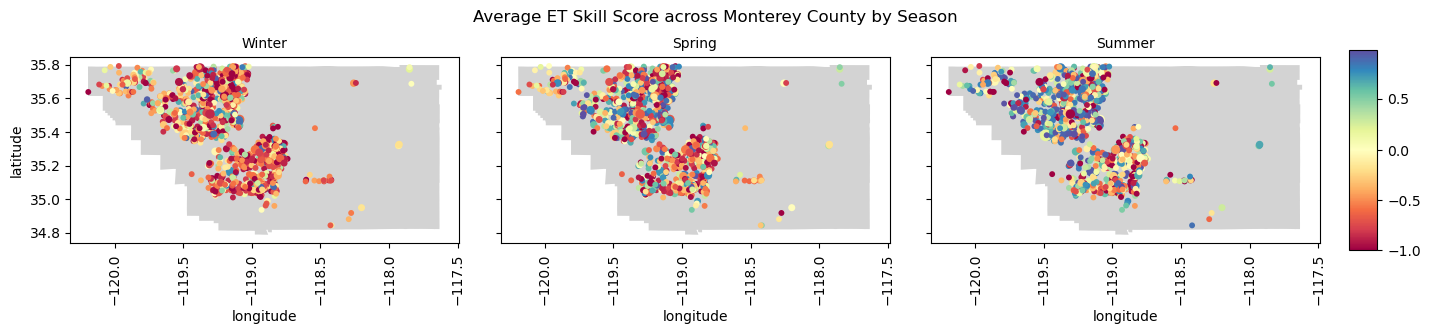

In [45]:
facet_geoscatter(et_seasonal, boundary_map=keco_geo, col='season', hue='skill_score', palette='Spectral', size='markersize',
                 as_percent=False, normalize_cmap=True, export_img="et_spatial_skill_score", 
                 col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                 title="Average ET Skill Score across Monterey County by Season");

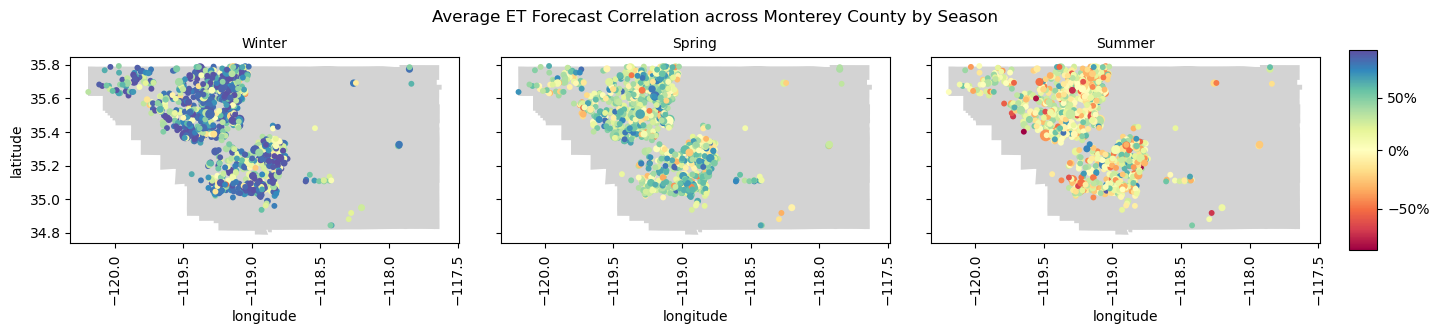

In [46]:
facet_geoscatter(et_seasonal, boundary_map=keco_geo, col='season', hue='corr', export_img="et_spatial_corr", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average ET Forecast Correlation across Monterey County by Season", palette='Spectral');

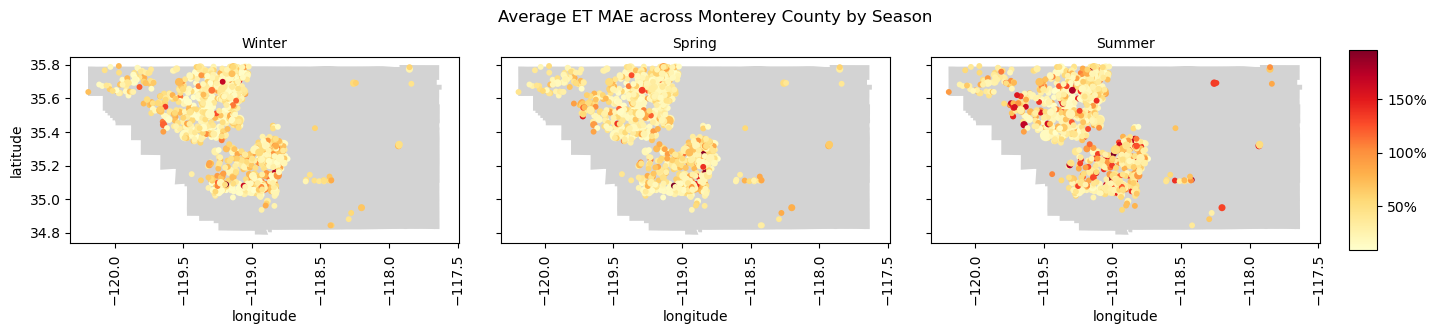

In [47]:
facet_geoscatter(et_seasonal, boundary_map=keco_geo, col='season', hue='mae',export_img="et_spatial_mae", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average ET MAE across Monterey County by Season");

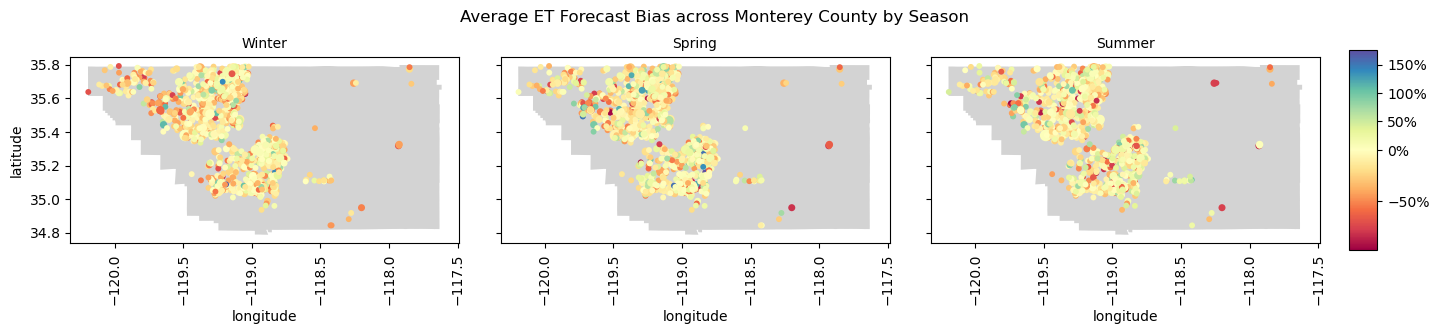

In [48]:
facet_geoscatter(et_seasonal, boundary_map=keco_geo, col='season', hue='bias', palette='Spectral', export_img="et_spatial_bias", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average ET Forecast Bias across Monterey County by Season");

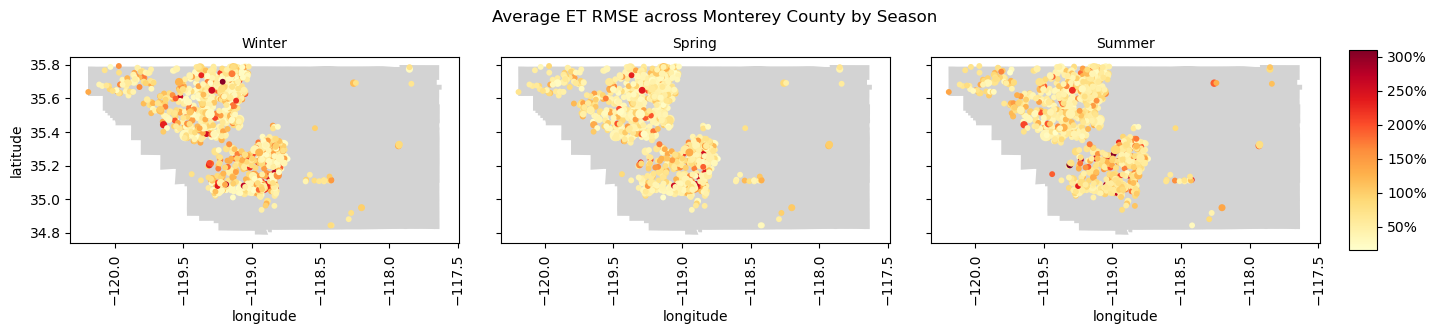

In [49]:
facet_geoscatter(et_seasonal, boundary_map=keco_geo, col='season', hue='rmse', export_img="et_spatial_rmse", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average ET RMSE across Monterey County by Season");

#### ETo Visualization

In [50]:
eto_seasonal = seasonal_metrics[seasonal_metrics['variable'] == 'ETo']

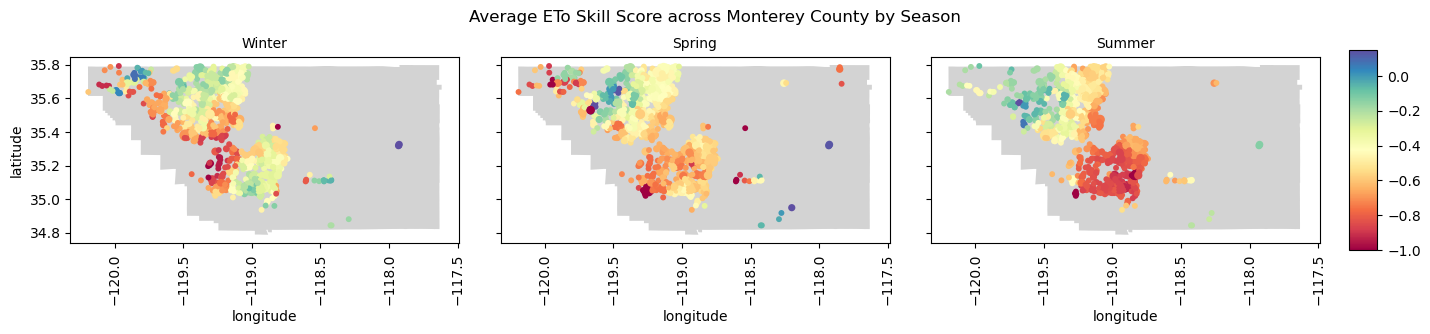

In [51]:
facet_geoscatter(eto_seasonal, boundary_map=keco_geo, col='season', hue='skill_score', export_img="eto_spatial_skill_score", as_percent=False, size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"}, # normalize_cmap=True,
                     title="Average ETo Skill Score across Monterey County by Season", palette='Spectral');

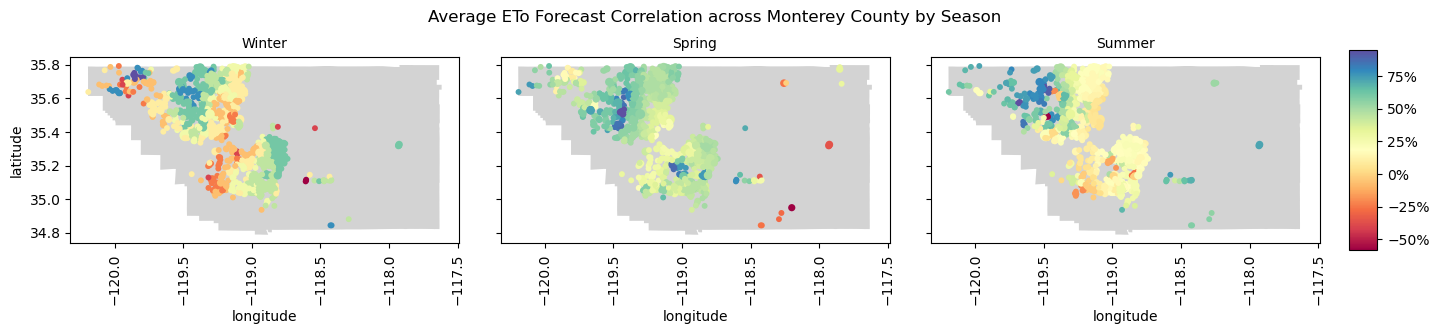

In [52]:
facet_geoscatter(eto_seasonal, boundary_map=keco_geo, col='season', hue='corr', export_img="eto_spatial_corr", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},# normalize_cmap=True,
                     title="Average ETo Forecast Correlation across Monterey County by Season", palette='Spectral');

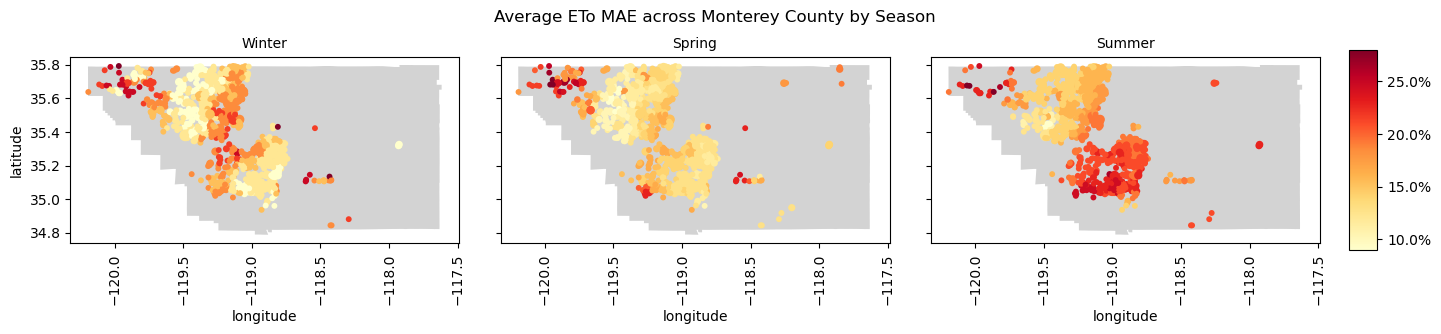

In [53]:
facet_geoscatter(eto_seasonal, boundary_map=keco_geo, col='season', hue='mae',export_img="eto_spatial_mae", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average ETo MAE across Monterey County by Season");

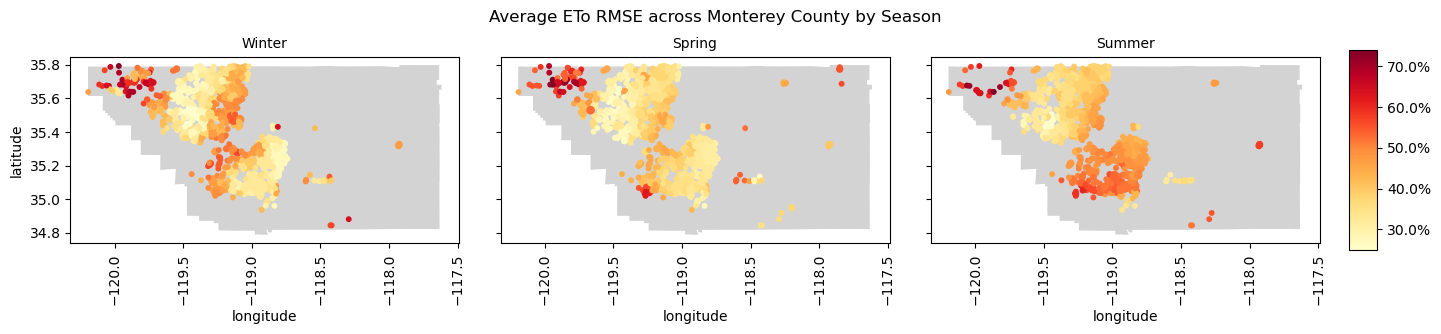

In [54]:
facet_geoscatter(eto_seasonal, boundary_map=keco_geo, col='season', hue='rmse', export_img="eto_spatial_rmse", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average ETo RMSE across Monterey County by Season");

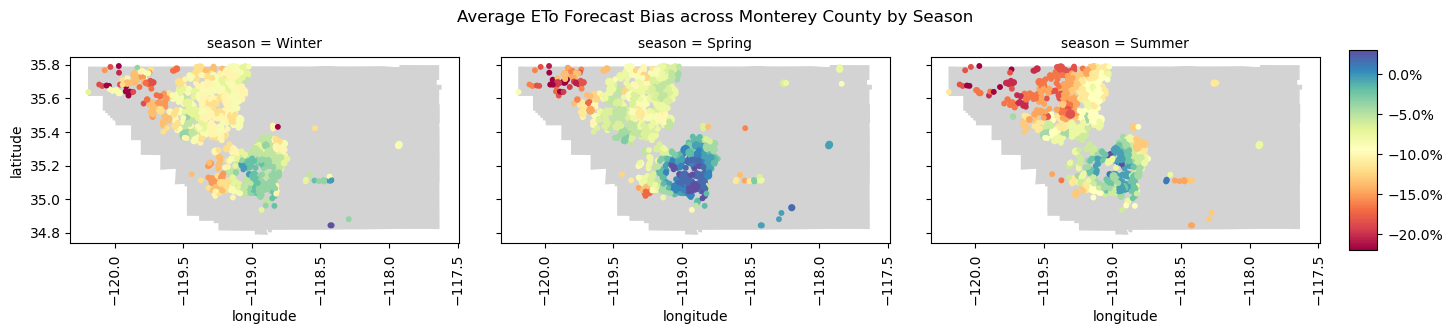

In [55]:
facet_geoscatter(eto_seasonal, boundary_map=keco_geo, col='season', hue='bias', palette='Spectral', export_img="eto_spatial_bias", size='markersize',
                     col_order=['Winter', 'Spring', 'Summer'],# normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average ETo Forecast Bias across Monterey County by Season");

#### EToF Visualization

In [56]:
etof_seasonal = seasonal_metrics[seasonal_metrics['variable'] == 'ETof']

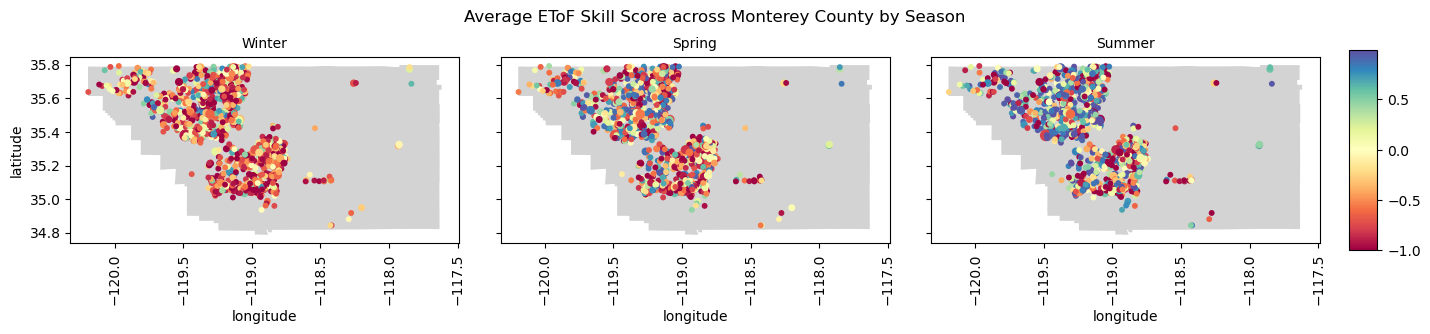

In [57]:
facet_geoscatter(etof_seasonal, boundary_map=keco_geo, col='season', hue='skill_score', size='markersize', export_img="etof_spatial_skill_score", as_percent=False,
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average EToF Skill Score across Monterey County by Season", palette='Spectral');

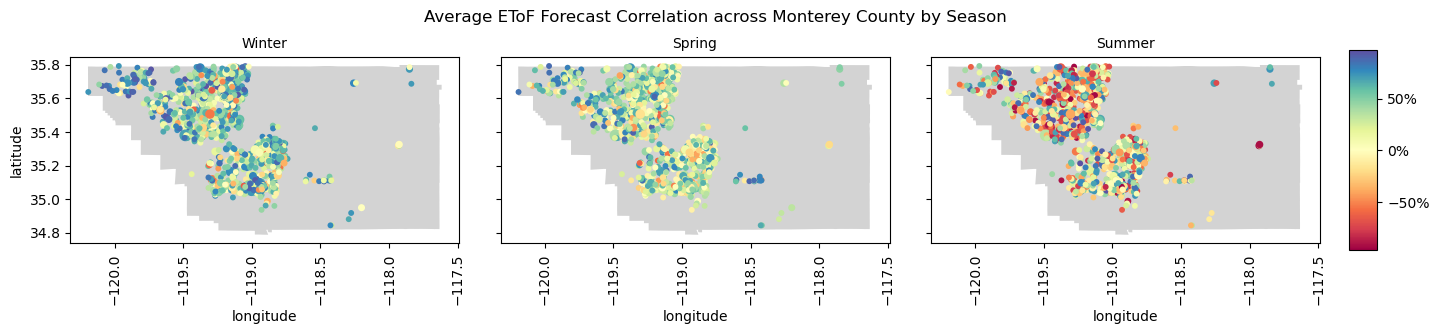

In [58]:
facet_geoscatter(etof_seasonal, boundary_map=keco_geo, col='season', hue='corr', size='markersize', export_img="etof_spatial_corr",
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average EToF Forecast Correlation across Monterey County by Season", palette='Spectral');

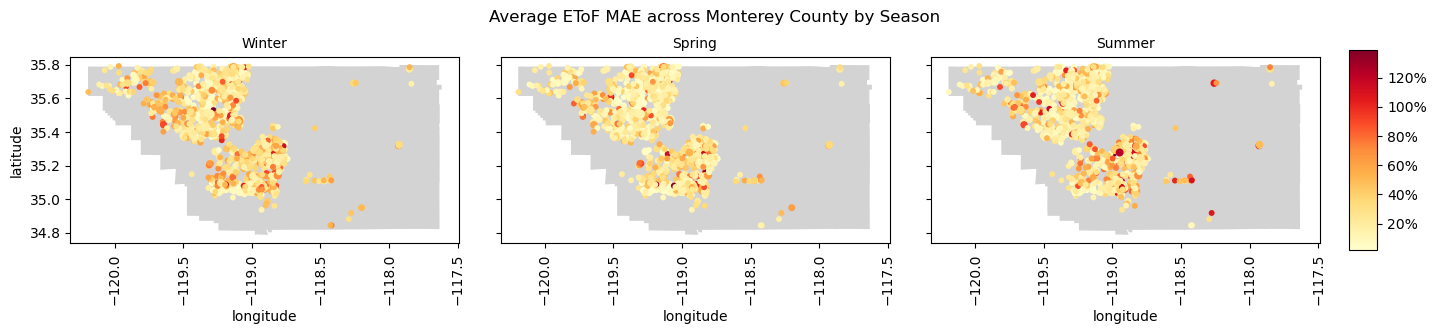

In [59]:
facet_geoscatter(etof_seasonal, boundary_map=keco_geo, col='season', hue='mae', size='markersize', export_img="etof_spatial_mae",
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average EToF MAE across Monterey County by Season");

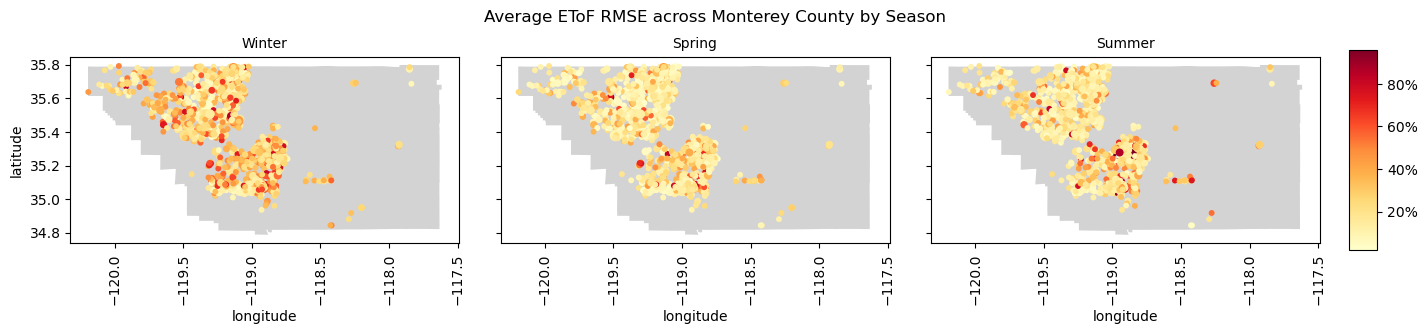

In [60]:
facet_geoscatter(etof_seasonal, boundary_map=keco_geo, col='season', hue='rmse', size='markersize', export_img="etof_spatial_rmse",
                     col_order=['Winter', 'Spring', 'Summer'], title_template={"template":"{col_name}"},
                     title="Average EToF RMSE across Monterey County by Season");

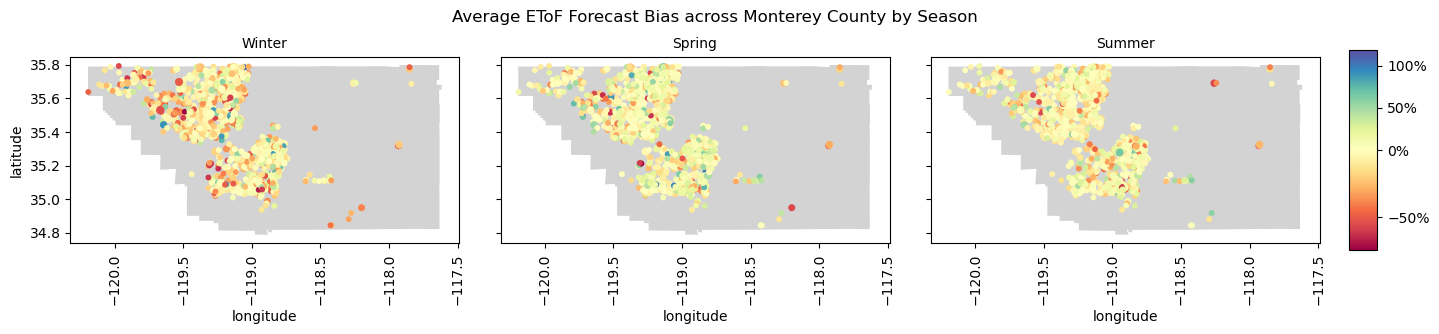

In [61]:
facet_geoscatter(etof_seasonal, boundary_map=keco_geo, col='season', hue='bias', size='markersize', palette='Spectral', export_img="etof_spatial_bias",
                     col_order=['Winter', 'Spring', 'Summer'], normalize_cmap=True, title_template={"template":"{col_name}"},
                     title="Average EToF Forecast Bias across Monterey County by Season");

#### Summer Overview

In [62]:
summer_metrics = seasonal_metrics[seasonal_metrics['season'] == 'Summer'][['field_id', 'variable', 'longitude', 'latitude', 'mae', 'bias', 'skill_score', 'markersize']]
summer_metrics = summer_metrics.melt(id_vars=['field_id', 'variable', 'longitude', 'latitude', 'markersize'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')
summer_metrics.head()

field_id variable   longitude   latitude  markersize stat  value
0   CA_27267       ET -119.969497  35.792434         2.0  mae   0.29
1   CA_27267      ETo -119.969497  35.792434         2.0  mae   0.18
2   CA_27267     ETof -119.969497  35.792434         2.0  mae   0.17
3  CA_297922       ET -119.229705  35.750524         2.0  mae   0.63
4  CA_297922      ETo -119.229705  35.750524         2.0  mae   0.12

In [63]:
# Add subtitles into the data to insert into the plots
subtitle_dict = {
    'mae': 'Mean Absolute Error',
    'bias': 'Forecast Bias',
    'skill_score': 'Skill Score'
}
summer_metrics['name'] = summer_metrics['stat'].map(subtitle_dict)

In [64]:
# Keyword for double-sided legend
sm_skill_score = summer_metrics[summer_metrics['stat'] == 'skill_score']

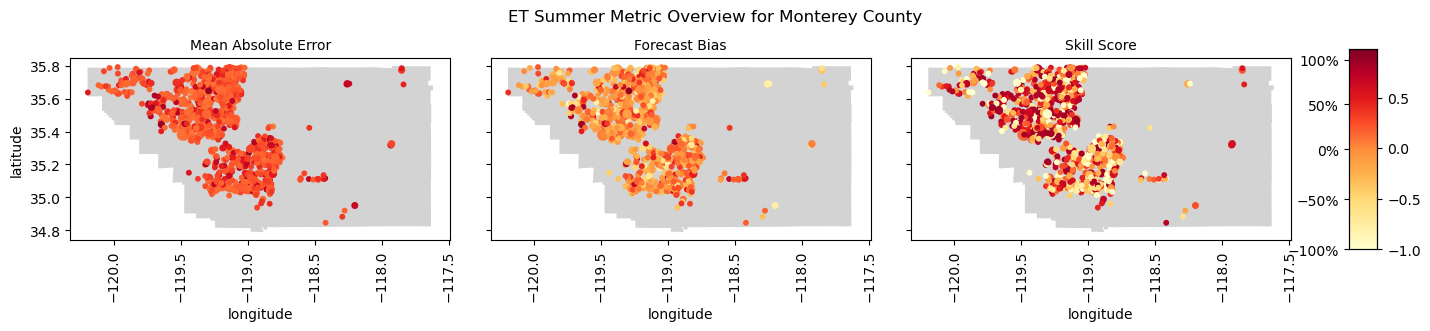

In [65]:
# Create subplot grid for each metric
g = facet_geoscatter(summer_metrics[summer_metrics['variable'] == 'ET'], boundary_map=keco_geo, col='name', hue='value', size='markersize', normalize_cmap=True,
                     title='ET Summer Metric Overview for Monterey County', title_template={"template": "{col_name}"}, export_img="et_summer_spatial",
                     double_legend=sm_skill_score[sm_skill_score['variable'] == 'ET']);

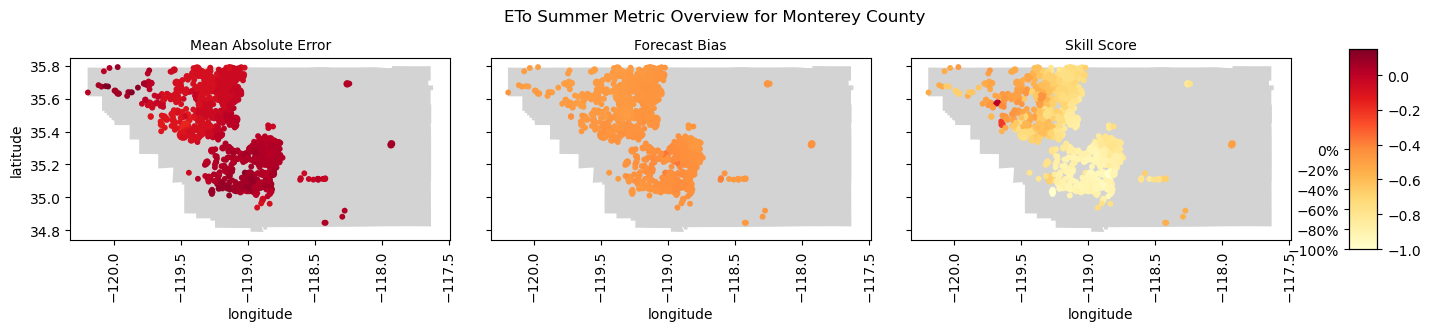

In [66]:
# Create subplot grid for each metric
g = facet_geoscatter(summer_metrics[summer_metrics['variable'] == 'ETo'], boundary_map=keco_geo, col='name', hue='value', size='markersize', normalize_cmap=True,
                     title='ETo Summer Metric Overview for Monterey County', title_template={"template": "{col_name}"}, export_img="eto_summer_spatial",
                     double_legend=sm_skill_score[sm_skill_score['variable'] == 'ETo']);

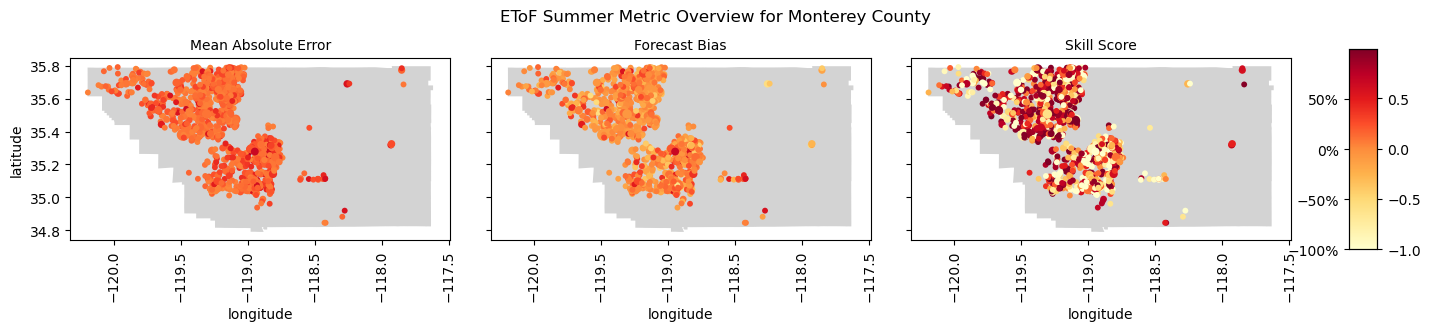

In [67]:
# Create subplot grid for each metric
g = facet_geoscatter(summer_metrics[summer_metrics['variable'] == 'ETof'], boundary_map=keco_geo, col='name', hue='value', size='markersize', normalize_cmap=True,
                     title='EToF Summer Metric Overview for Monterey County', title_template={"template": "{col_name}"}, export_img="etof_summer_spatial",
                     double_legend=sm_skill_score[sm_skill_score['variable'] == 'ETof']);